In [26]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [27]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### Note
If you haven't seen `nn.Sequential` yet, please finish the end of the Part 2 notebook.

In [28]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3119, grad_fn=<NllLossBackward>)


In [29]:
# TODO: Build a feed-forward network
model = nn.Sequential(
    nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.LogSoftmax(dim=1)
)

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2981, grad_fn=<NllLossBackward>)


## Autograd

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [30]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.7005,  2.6598],
        [-0.5403,  0.9711]], requires_grad=True)


In [31]:
y = x**2
print(y)

tensor([[0.4907, 7.0745],
        [0.2919, 0.9430]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [32]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [33]:
z = y.mean()
print(z)

tensor(2.2000, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [34]:
print(x.grad)

None


In [35]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.3503,  1.3299],
        [-0.2701,  0.4855]])
tensor([[-0.3503,  1.3299],
        [-0.2701,  0.4855]], grad_fn=<DivBackward0>)


In [36]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [37]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [-0.0050, -0.0050, -0.0050,  ..., -0.0050, -0.0050, -0.0050],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        ...,
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0022,  0.0022,  0.0022,  ...,  0.0022,  0.0022,  0.0022],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005]])


In [38]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [39]:
print('Initial weights - ', model[0].weight)

dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0088, -0.0141,  0.0258,  ...,  0.0016, -0.0079,  0.0100],
        [ 0.0099, -0.0351, -0.0071,  ...,  0.0013, -0.0355, -0.0120],
        [ 0.0084, -0.0041,  0.0227,  ...,  0.0270,  0.0019, -0.0305],
        ...,
        [-0.0122,  0.0203,  0.0020,  ...,  0.0012,  0.0150, -0.0017],
        [ 0.0079, -0.0317, -0.0173,  ..., -0.0178,  0.0127,  0.0182],
        [ 0.0309, -0.0275,  0.0138,  ...,  0.0303,  0.0192, -0.0212]],
       requires_grad=True)
Gradient - tensor([[-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020],
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0031, -0.0031, -0.0031,  ..., -0.0031, -0.0031, -0.0031],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003]])


In [40]:
# Take an update step and view the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0088, -0.0141,  0.0258,  ...,  0.0016, -0.0079,  0.0100],
        [ 0.0100, -0.0350, -0.0071,  ...,  0.0013, -0.0355, -0.0120],
        [ 0.0084, -0.0041,  0.0227,  ...,  0.0270,  0.0020, -0.0305],
        ...,
        [-0.0122,  0.0203,  0.0020,  ...,  0.0012,  0.0150, -0.0017],
        [ 0.0080, -0.0317, -0.0172,  ..., -0.0178,  0.0127,  0.0183],
        [ 0.0309, -0.0275,  0.0138,  ...,  0.0303,  0.0192, -0.0212]],
       requires_grad=True)


In [58]:
## Your solution here

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output,labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.902354075329136
Training loss: 0.8317925732717839
Training loss: 0.5100187009839869
Training loss: 0.42363458018757894
Training loss: 0.3839636096742743


With the network trained, we can check out it's predictions.

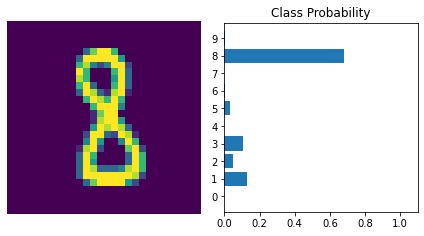

In [62]:
%matplotlib inline
import helper

dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)